![](https://raw.githubusercontent.com/cengineer13/modern_computer_vision/main/LOGO.png)

# **Colorize Black and White Photos using a Caffe Model in OpenCV**

**In this lesson we'll learn how to use pre-trained models to automatically Colorize a Black and White (grayscale) Photo**
https://github.com/richzhang/colorization/blob/master/colorize.py

### **Colorizing black and white images is an amazingly useful and incredible technique achieved by deep learning.** 

[Colorful Image Colorization ](http://arxiv.org/pdf/1603.08511.pdf) 

- The authors embrace the underlying uncertainty of the problem (black and white to color conversion) by posing it as a classification task and use class-rebalancing at training time to increase the diversity of colors in the result. 
- The system is implemented as a feed-forward pass in a CNN at test time and is trained on over a million color images. 
- They evaluate our algorithm using a “colorization Turing test,” asking human participants to choose between a generated and ground truth color image. 
- Their method successfully fools humans on 32% of the trials, significantly higher than previous methods.

![](http://richzhang.github.io/colorization/resources/images/teaser3.jpg)

by Richard Zhang, Phillip Isola, Alexei A. Efros. In ECCV, 2016.

We'll be using the following Caffe model files that we'll download in the next cell below. These will be then loaded into OpenCV:

1. colorization_deploy_v2.prototext
2. colorization_release_v2.caffe
3. pts_in_hull.npy


<b>FOR more:<b/>https://pyimagesearch.com/2019/02/25/black-and-white-image-colorization-with-opencv-and-deep-learning/

<b> Lab color space</b>
![](https://www.researchgate.net/profile/Sudhir-Shukla-3/publication/23789543/figure/fig3/AS:276894424551429@1443028183655/The-cubical-CIE-Lab-color-space.png)

Similar to the RGB color space, the Lab color space has three channels. But unlike the RGB color space, Lab encodes color information differently:

The L channel encodes lightness intensity only
The a channel encodes green-red.
And the b channel encodes blue-yellow

## Entire process summarized as: 

- 1. Convert all training images from the RGB color space to the Lab color space.
- 2. Use the L channel as the input to the network and train the network to predict the ab channels.
- 3. Combine the input L channel with the predicted ab channels.
- 4. Convert the Lab image back to RGB.

In [100]:
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt

# Define our imshow function 
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

# 1. Colorazation from Image (Pyimagesearch edition)

In [31]:
print("[INFO] Loading model....")

PROTOTEXT = "Datasets/colorize/colorization_deploy_v2.prototxt"
CAFFE_MODEL = "Datasets/colorize/colorization_release_v2.caffemodel"

#modelni config va weightslari bn yuklab olamiz
model = cv2.dnn.readNetFromCaffe(PROTOTEXT, CAFFE_MODEL)
print(model.getLayerNames()) #layerlarni nomlarini chiqarish

# Kernel for model
pts = np.load("Datasets/colorize/pts_in_hull.npy")

# add the cluster centers as 1x1 convolutions to the model
class8 = model.getLayerId("class8_ab") #class8 ni indexini ovolyapmiz
conv8 = model.getLayerId("conv8_313_rh") 
pts = pts.transpose().reshape(2, 313, 1, 1)

#get neccesary layers and apply each pts kernel
model.getLayer(class8).blobs = [pts.astype('float32')]
model.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]




[INFO] Loading model....
['conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'conv1_2norm', 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'conv2_2norm', 'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'conv3_3norm', 'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'conv4_3norm', 'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'conv5_3norm', 'conv6_1', 'relu6_1', 'conv6_2', 'relu6_2', 'conv6_3', 'relu6_3', 'conv6_3norm', 'conv7_1', 'relu7_1', 'conv7_2', 'relu7_2', 'conv7_3', 'relu7_3', 'conv7_3norm', 'conv8_1', 'relu8_1', 'conv8_2', 'relu8_2', 'conv8_3', 'relu8_3', 'conv8_313', 'conv8_313_rh', 'class8_313_rh', 'class8_ab', 'Silence']


In [108]:
# load the input image from disk, scale the pixel intensities to the
# range [0, 1], and then convert the image from the BGR to Lab color
image = cv2.imread("Datasets/colorize/blackandwhite/BruceLee.jpg")
scaled = image.astype('float32') / 255.0 
lab  = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)

# resize the Lab image to 224x224 (the dimensions the colorization
# network accepts, split channels,
resized = cv2.resize(lab, (224, 224))
L = cv2.split(resized)[0] #extract the 'L' channel
L -= 50  # perform mean centering

In [109]:
# pass the L channel through the network which will *predict* the 'a'
# and 'b' channel values
print("[INFO] colorizing image...")

model.setInput(cv2.dnn.blobFromImage(L))

#model forward qilamiz va u bizga a va b ta channelni predict qiladi
predicted_ab = model.forward('class8_ab')[0, :, :, :].transpose((1,2,0))  #(1, 2, 56, 56) - > (56, 56, 2)
print(predicted_ab.shape) 

# predicted_ab = np.squeeze(ab).transpose(1,2,0)
# print(predicted_ab.shape)

# resize the predicted 'ab' volume to the same dimensions as our input image 
predicted_ab = cv2.resize(predicted_ab, (image.shape[1], image.shape[0]))


[INFO] colorizing image...
(56, 56, 2)


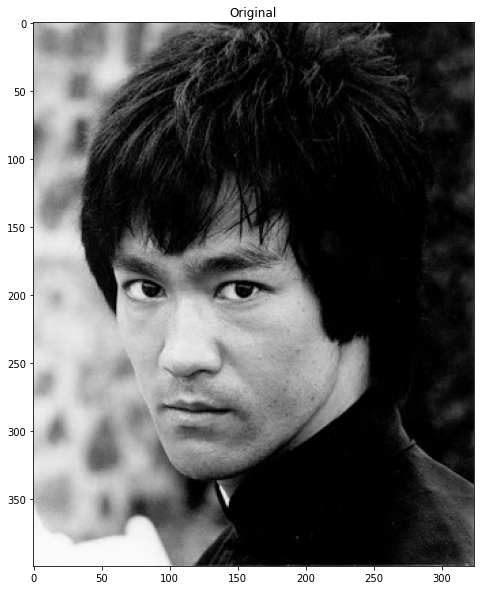

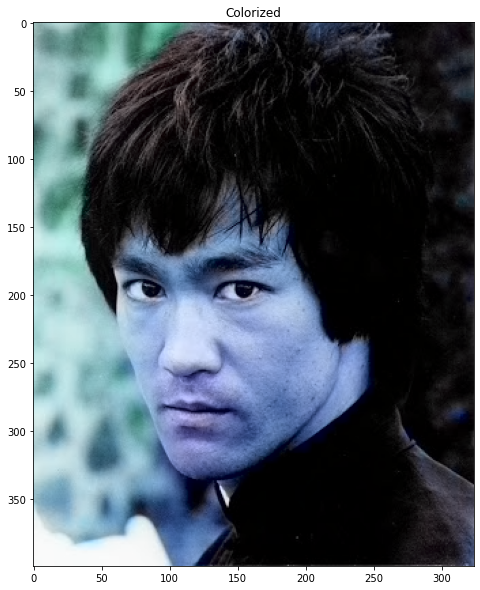

In [110]:
# grab the 'L' channel from the *original* input image (not the
# resized one) and concatenate the original 'L' channel with the
# predicted 'ab' channels
L = cv2.split(lab)[0]
colorized = np.concatenate((L[:,:,np.newaxis], predicted_ab), axis=2)

# convert the output image from the Lab color space to RGB, then
colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2RGB)
# clip any values that fall outside the range [0, 1]
colorized = np.clip(colorized, 0, 1)

# the current colorized image is represented as a floating point
# data type in the range [0, 1] -- let's convert to an unsigned
# 8-bit integer representation in the range [0, 255] 
colorized = (255 *  colorized).astype('uint8')

# show the original and output colorized images
imshow("Original", image)
imshow("Colorized", colorized)


# 2. Colorazation from Image (Modern computer vision edition)

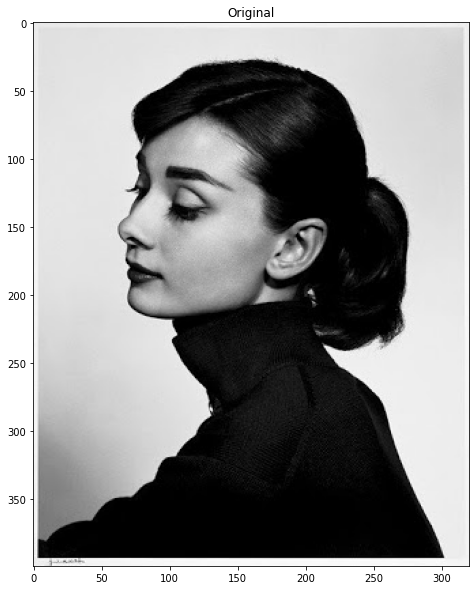

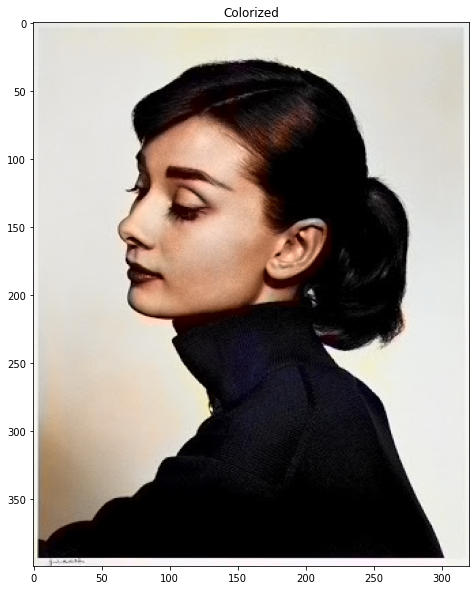

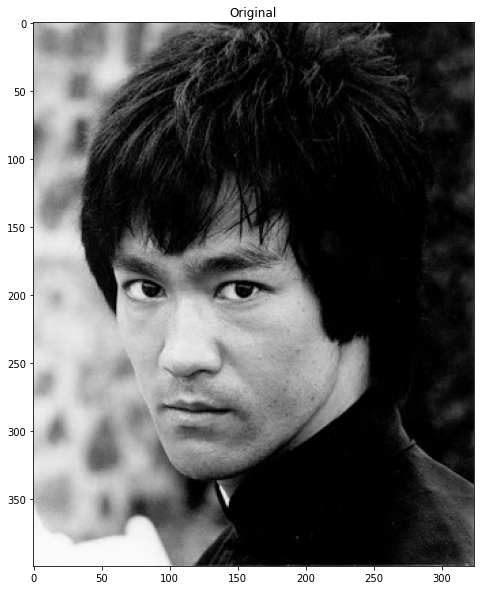

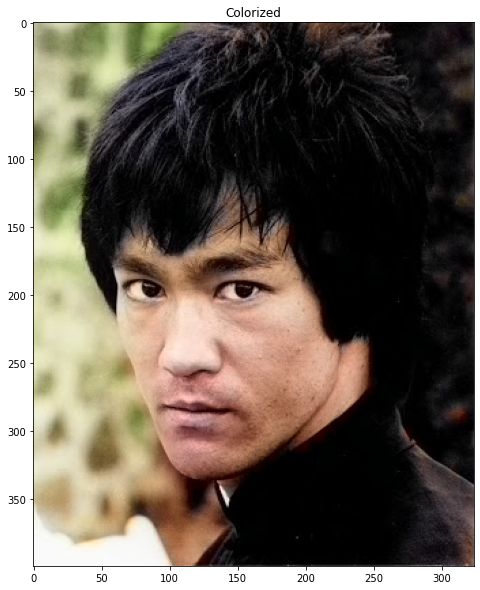

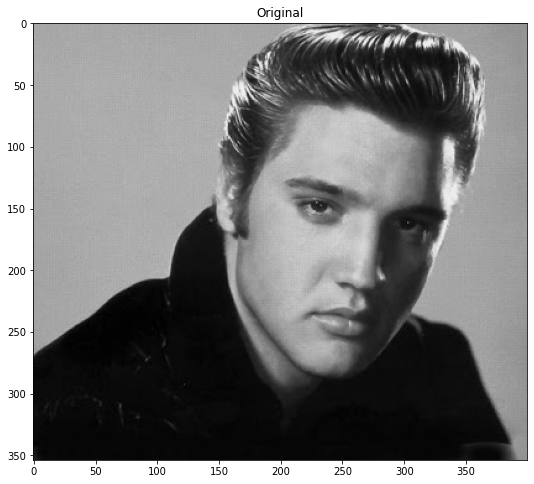

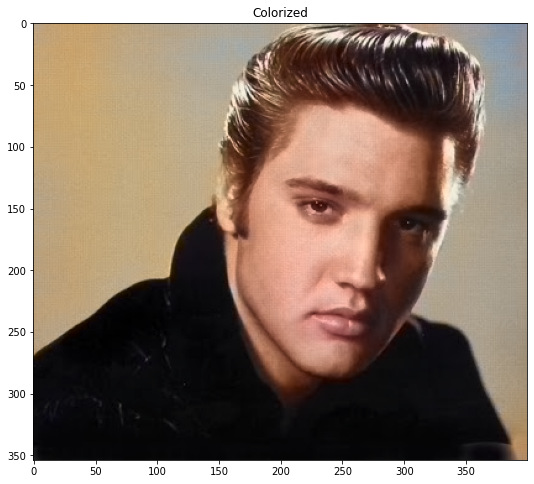

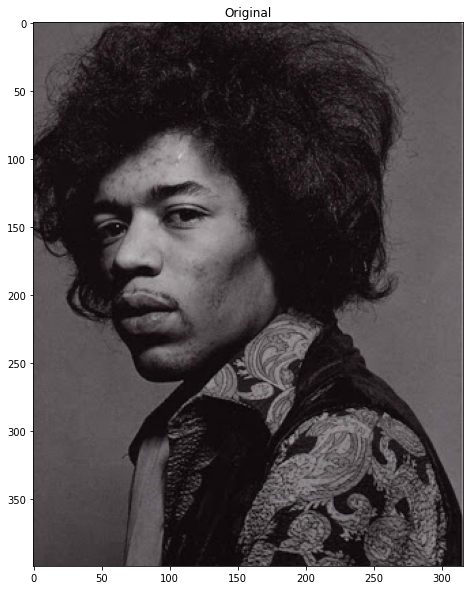

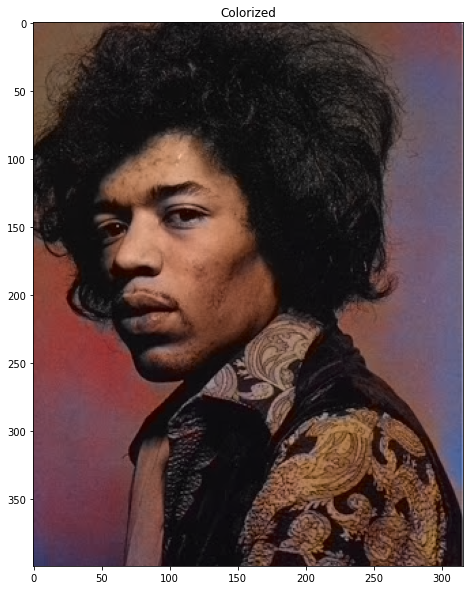

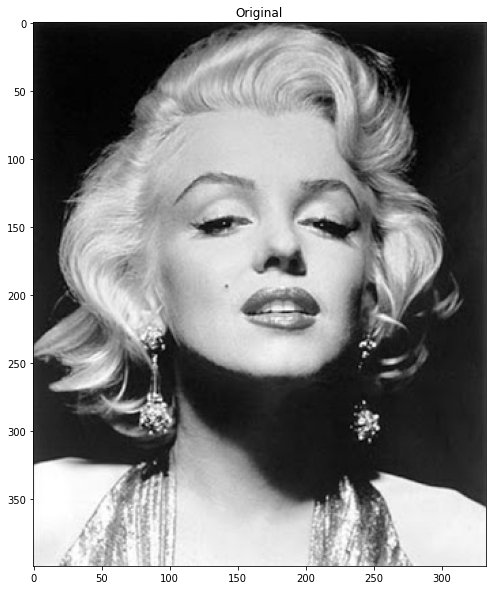

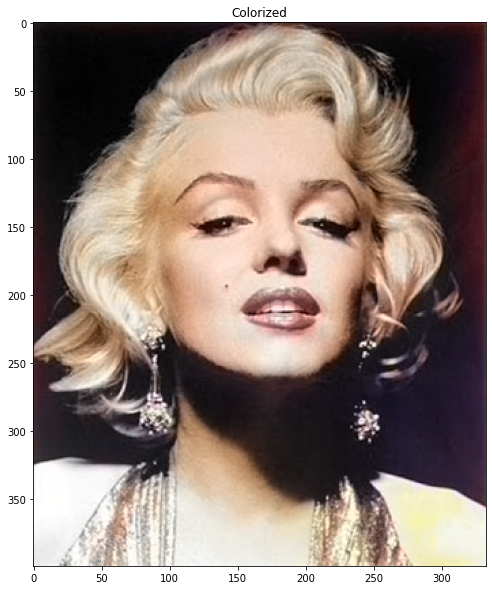

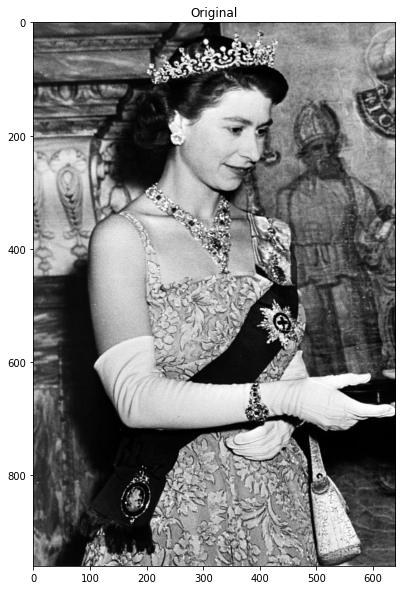

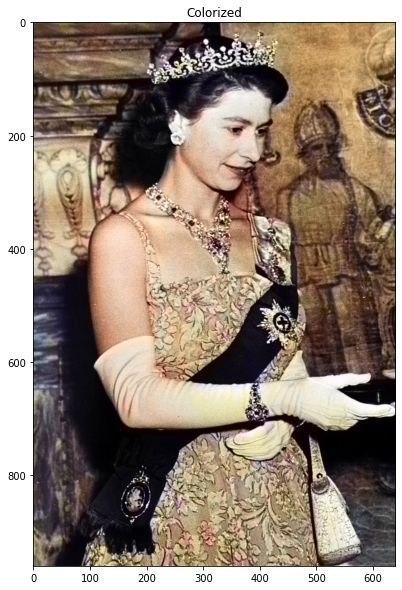

In [102]:

# Script is based on https://github.com/richzhang/colorization/blob/master/colorize.py
# To download the caffemodel and the prototxt, see: https://github.com/richzhang/colorization/tree/master/models
# To download pts_in_hull.npy, see: https://github.com/richzhang/colorization/blob/master/resources/pts_in_hull.npy

# Get our images
file_path = "Datasets/colorize/blackandwhite/"
blackandwhite_imgs = [f for f in listdir(file_path) if isfile(join(file_path, f))]
kernel = 'Datasets/colorize/pts_in_hull.npy'

# Start the main program
if __name__ == '__main__':

    # Select desired model
    net = cv2.dnn.readNetFromCaffe("Datasets/colorize/colorization_deploy_v2.prototxt",
                               "Datasets/colorize/colorization_release_v2.caffemodel")

    # load cluster centers
    pts_in_hull = np.load(kernel) 

    # populate cluster centers as 1x1 convolution kernel
    pts_in_hull = pts_in_hull.transpose().reshape(2, 313, 1, 1)
    net.getLayer(net.getLayerId('class8_ab')).blobs = [pts_in_hull.astype(np.float32)]
    net.getLayer(net.getLayerId('conv8_313_rh')).blobs = [np.full([1, 313], 2.606, np.float32)]

    for image in blackandwhite_imgs:
        img = cv2.imread(file_path+image)
        
        img_rgb = (img[:,:,[2, 1, 0]] * 1.0 / 255).astype(np.float32)
        img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2LAB)
        
        # pull out L channel
        img_l = img_lab[:,:,0]
        
        # get original image size
        (H_orig,W_orig) = img_rgb.shape[:2] 

        # resize image to network input size
        img_rs = cv2.resize(img_rgb, (224, 224)) 
        
        # resize image to network input size
        img_lab_rs = cv2.cvtColor(img_rs, cv2.COLOR_RGB2Lab)
        img_l_rs = img_lab_rs[:,:,0]
        
        # subtract 50 for mean-centering
        img_l_rs -= 50 

        net.setInput(cv2.dnn.blobFromImage(img_l_rs))
        
        # this is our result
        ab_dec = net.forward('class8_ab')[0,:,:,:].transpose((1,2,0)) 

        (H_out,W_out) = ab_dec.shape[:2]
        ab_dec_us = cv2.resize(ab_dec, (W_orig, H_orig))
        img_lab_out = np.concatenate((img_l[:,:,np.newaxis],ab_dec_us),axis=2) 
        
        # concatenate with original image L
        img_bgr_out = np.clip(cv2.cvtColor(img_lab_out, cv2.COLOR_Lab2BGR), 0, 1)

        # show original image
        imshow('Original', img)
        # Resize the corlized image to it's orginal dimensions 
        img_bgr_out = cv2.resize(img_bgr_out, (W_orig, H_orig), interpolation = cv2.INTER_AREA)
        imshow('Colorized', img_bgr_out)